### Import Library

In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

import re
from tqdm import tqdm

In [502]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [420]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1490518631934826107
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12069283383976788223
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [421]:
data = pd.read_csv("data/data.csv")

In [422]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_C,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0


### Processing missing data & Drop unnecessary data

In [423]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

In [424]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve'], axis = 1)

### train / test split

In [425]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [426]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

test = test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [427]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166 entries, 670 to 1162
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1166 non-null   float64
 1   As              1166 non-null   float64
 2   slope           1166 non-null   float64
 3   altitude        1166 non-null   float64
 4   profile_c_num   1166 non-null   float64
 5   profile_c_abs   1166 non-null   int64  
 6   planform_c_num  1166 non-null   float64
 7   planform_c_abs  1166 non-null   int64  
 8   HYDGRP_A        1166 non-null   int64  
 9   HYDGRP_B        1166 non-null   int64  
 10  HYDGRP_C        1166 non-null   int64  
 11  HYDGRP_D        1166 non-null   int64  
 12  ANION_EXCL      1166 non-null   float64
 13  SOL_CRK         1166 non-null   float64
 14  SOL_K1          1166 non-null   float64
 15  CLAY1           1166 non-null   float64
 16  SILT1           1166 non-null   float64
 17  SAND1           1166 non-null  

In [428]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 61 to 353
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              292 non-null    float64
 1   slope           292 non-null    float64
 2   altitude        292 non-null    float64
 3   profile_c_num   292 non-null    float64
 4   profile_c_abs   292 non-null    int64  
 5   planform_c_num  292 non-null    float64
 6   planform_c_abs  292 non-null    int64  
 7   HYDGRP_A        292 non-null    int64  
 8   HYDGRP_B        292 non-null    int64  
 9   HYDGRP_C        292 non-null    int64  
 10  HYDGRP_D        292 non-null    int64  
 11  ANION_EXCL      292 non-null    float64
 12  SOL_CRK         292 non-null    float64
 13  SOL_K1          292 non-null    float64
 14  CLAY1           292 non-null    float64
 15  SILT1           292 non-null    float64
 16  SAND1           292 non-null    float64
 17  ROCK1           292 non-null    fl

### Check the value skewed

#### As

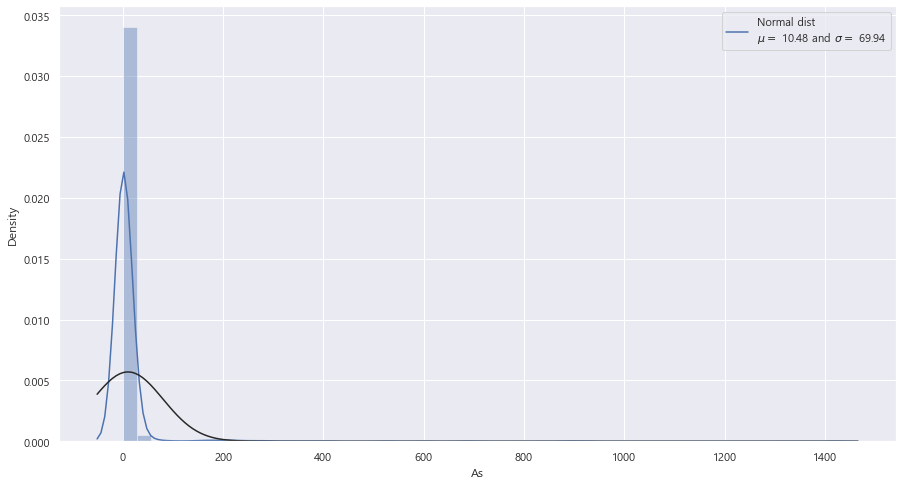

In [429]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

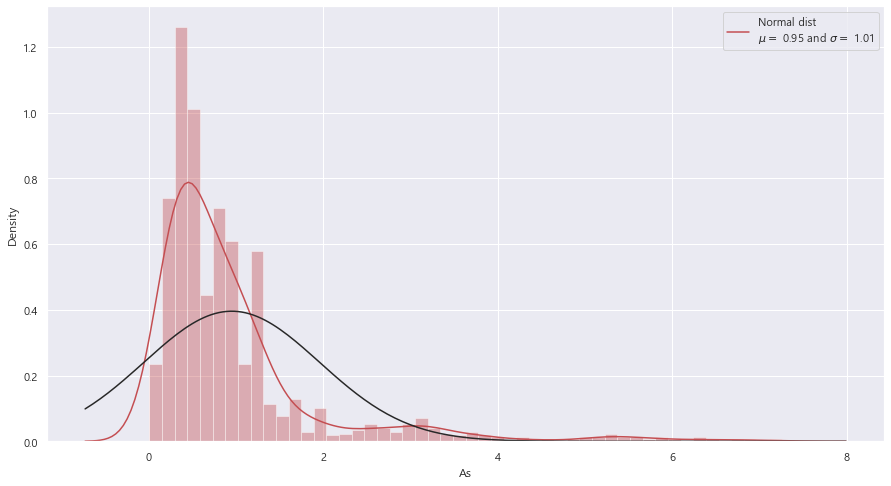

In [430]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

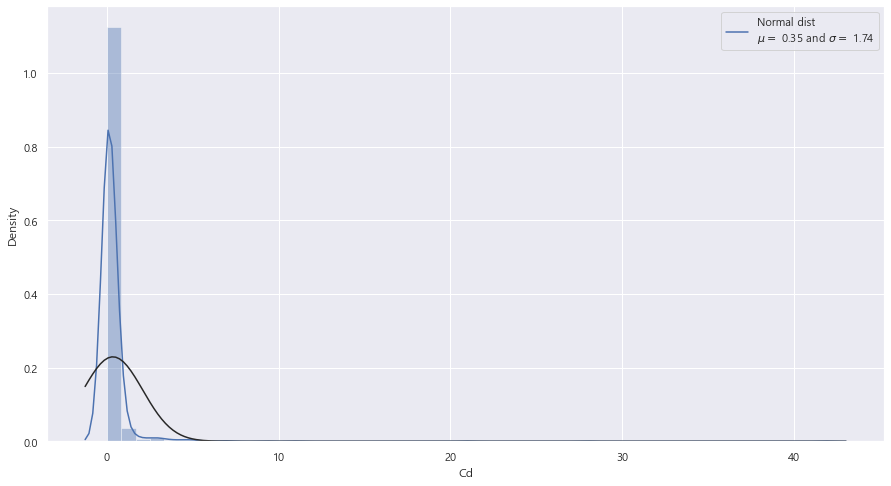

In [431]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

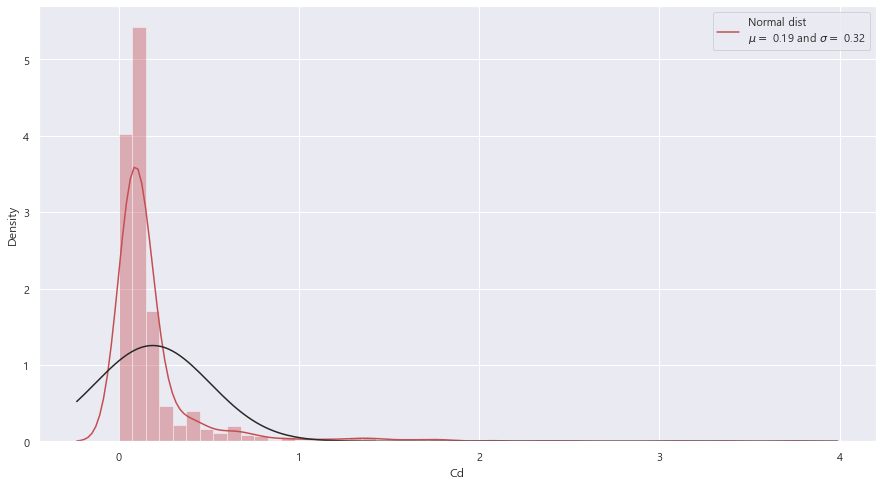

In [432]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

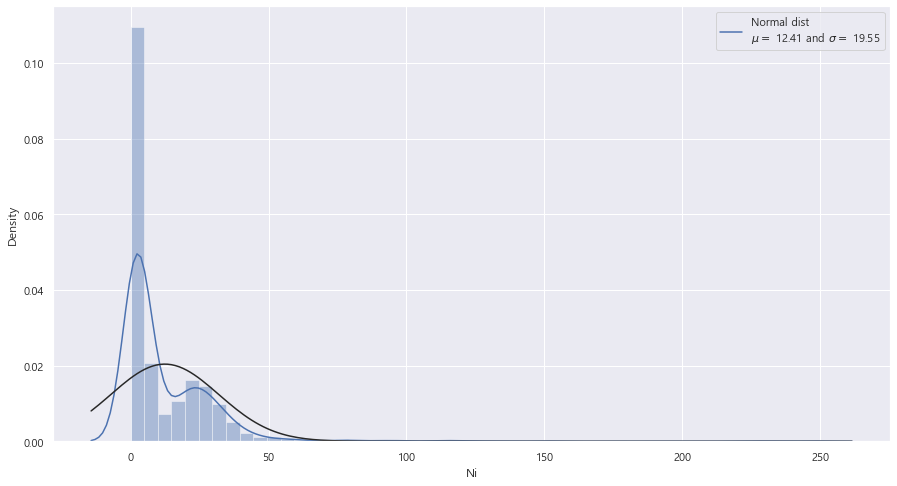

In [433]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

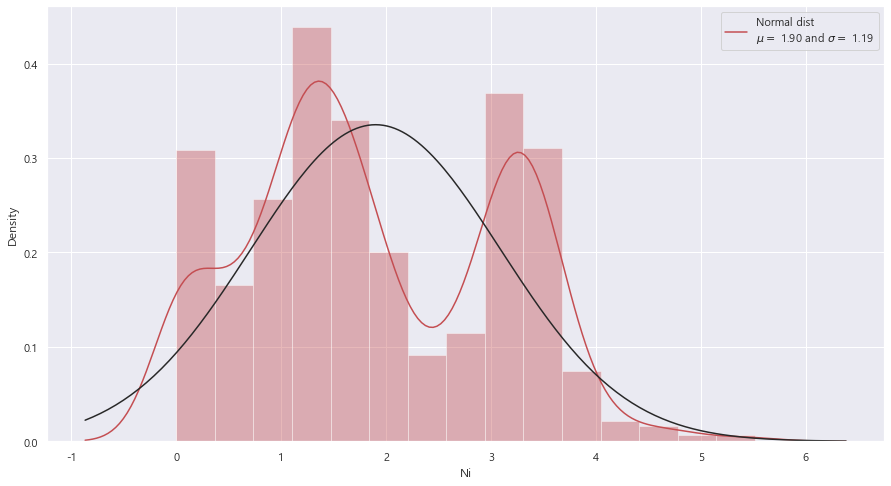

In [434]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [435]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

#### Scaling

In [436]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [437]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

As_X = pd.DataFrame(scaler.fit_transform(As_X), columns=As_X.columns)
Cd_X = pd.DataFrame(scaler.fit_transform(Cd_X), columns=Cd_X.columns)
Ni_X = pd.DataFrame(scaler.fit_transform(Ni_X), columns=Ni_X.columns)

#### 10-Fold Crossvalidation

In [438]:
kf = KFold(n_splits = 10, random_state = 605, shuffle = True)

#### 1) NGBRegressor

In [527]:
ngb = NGBRegressor(random_state = 605, n_estimators = 300, learning_rate=0.001)

In [528]:
As_ngb_pred = np.zeros((test.shape[0]))
rmse_list = []

for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 10
    As_ngb_pred += sub_pred

print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

[iter 0] loss=1.4511 val_loss=0.0000 scale=1.0000 norm=1.0152
[iter 100] loss=1.3629 val_loss=0.0000 scale=1.0000 norm=0.9403
[iter 200] loss=1.3060 val_loss=0.0000 scale=1.0000 norm=0.9024
[iter 0] loss=1.2339 val_loss=0.0000 scale=2.0000 norm=1.7337
[iter 100] loss=1.1965 val_loss=0.0000 scale=2.0000 norm=1.7025
[iter 200] loss=1.1645 val_loss=0.0000 scale=2.0000 norm=1.6805
[iter 0] loss=1.1250 val_loss=0.0000 scale=1.0000 norm=0.8214
[iter 100] loss=1.1074 val_loss=0.0000 scale=1.0000 norm=0.8140
[iter 200] loss=1.0897 val_loss=0.0000 scale=2.0000 norm=1.6144
[iter 0] loss=1.0856 val_loss=0.0000 scale=1.0000 norm=0.8192
[iter 100] loss=1.0538 val_loss=0.0000 scale=1.0000 norm=0.8038
[iter 200] loss=1.0341 val_loss=0.0000 scale=1.0000 norm=0.7959
[iter 0] loss=1.0505 val_loss=0.0000 scale=1.0000 norm=0.7992
[iter 100] loss=1.0375 val_loss=0.0000 scale=1.0000 norm=0.7953
[iter 200] loss=1.0242 val_loss=0.0000 scale=1.0000 norm=0.7911
[iter 0] loss=1.0082 val_loss=0.0000 scale=1.0000 

In [518]:
Cd_ngb_pred = np.zeros((test.shape[0]))
rmse_list = []

for tr_idx, val_idx in kf.split(Cd_X, Cd_y) :
    tr_x, tr_y = Cd_X.iloc[tr_idx], Cd_y.iloc[tr_idx]
    val_x, val_y = Cd_X.iloc[val_idx], Cd_y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 10
    Cd_ngb_pred += sub_pred

print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')


[iter 0] loss=1.0960 val_loss=0.0000 scale=1.0000 norm=1.6875
[iter 100] loss=0.4653 val_loss=0.0000 scale=1.0000 norm=1.0131
[iter 200] loss=0.2702 val_loss=0.0000 scale=1.0000 norm=0.8105
[iter 0] loss=0.1870 val_loss=0.0000 scale=1.0000 norm=0.7514
[iter 100] loss=0.0895 val_loss=0.0000 scale=1.0000 norm=0.6642
[iter 200] loss=0.0224 val_loss=0.0000 scale=1.0000 norm=0.6127
[iter 0] loss=0.0037 val_loss=0.0000 scale=1.0000 norm=0.6086
[iter 100] loss=-0.0534 val_loss=0.0000 scale=1.0000 norm=0.5722
[iter 200] loss=-0.0887 val_loss=0.0000 scale=1.0000 norm=0.5549
[iter 0] loss=-0.1189 val_loss=0.0000 scale=1.0000 norm=0.5278
[iter 100] loss=-0.1481 val_loss=0.0000 scale=1.0000 norm=0.5223
[iter 200] loss=-0.1744 val_loss=0.0000 scale=2.0000 norm=1.0380
[iter 0] loss=-0.2265 val_loss=0.0000 scale=1.0000 norm=0.5344
[iter 100] loss=-0.2505 val_loss=0.0000 scale=1.0000 norm=0.5268
[iter 200] loss=-0.2695 val_loss=0.0000 scale=1.0000 norm=0.5222
[iter 0] loss=-0.2881 val_loss=0.0000 scal

In [519]:
Ni_ngb_pred = np.zeros((test.shape[0]))
rmse_list = []

for tr_idx, val_idx in kf.split(Ni_X, Ni_y) :
    tr_x, tr_y = Ni_X.iloc[tr_idx], Ni_y.iloc[tr_idx]
    val_x, val_y = Ni_X.iloc[val_idx], Ni_y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 10
    Ni_ngb_pred += sub_pred

print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')


[iter 0] loss=3.0135 val_loss=0.0000 scale=1.0000 norm=2.6957
[iter 100] loss=2.1456 val_loss=0.0000 scale=1.0000 norm=1.7778
[iter 200] loss=1.8613 val_loss=0.0000 scale=1.0000 norm=1.4791
[iter 0] loss=1.7281 val_loss=0.0000 scale=1.0000 norm=1.3384
[iter 100] loss=1.6354 val_loss=0.0000 scale=1.0000 norm=1.2435
[iter 200] loss=1.5749 val_loss=0.0000 scale=1.0000 norm=1.1820
[iter 0] loss=1.5285 val_loss=0.0000 scale=1.0000 norm=1.1375
[iter 100] loss=1.4906 val_loss=0.0000 scale=1.0000 norm=1.0999
[iter 200] loss=1.4618 val_loss=0.0000 scale=1.0000 norm=1.0712
[iter 0] loss=1.4496 val_loss=0.0000 scale=1.0000 norm=1.0550
[iter 100] loss=1.4307 val_loss=0.0000 scale=1.0000 norm=1.0366
[iter 200] loss=1.4116 val_loss=0.0000 scale=1.0000 norm=1.0182
[iter 0] loss=1.3864 val_loss=0.0000 scale=1.0000 norm=1.0028
[iter 100] loss=1.3720 val_loss=0.0000 scale=1.0000 norm=0.9903
[iter 200] loss=1.3593 val_loss=0.0000 scale=2.0000 norm=1.9596
[iter 0] loss=1.3487 val_loss=0.0000 scale=1.0000 

#### 2) RandomForestRegressor

In [442]:
rf = RandomForestRegressor(random_state = 605, n_estimators = 500)

In [443]:
rf_pred = np.zeros((test.shape[0]))
rmse_list = []

for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 10
    rf_pred += sub_pred

print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

RandomForestRegressor의 10fold 평균 RMSE는 55.29742028286144


#### 3) ExtraTreesRegressor

In [444]:
etc = ExtraTreesRegressor(random_state = 605, n_estimators = 500)

In [445]:
etc_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    etc.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 10
    etc_pred += sub_pred

print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

ExtraTreesRegressor의 10fold 평균 RMSE는 52.16136907184292


#### 4) GradientBoostingRegressor

In [446]:
gb = GradientBoostingRegressor(random_state = 605, max_depth = 5)

In [447]:
gb_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    gb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 10
    gb_pred += sub_pred

print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

GradientBoostingRegressor의 10fold 평균 RMSE는 54.95300639997912


#### 5) CatBoostRegressor

In [448]:
cb = CatBoostRegressor(random_state = 605, silent = True, depth = 3)

In [449]:
cb_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    cb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(test)]) / 10
    cb_pred += sub_pred

print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

CatBoostRegressor의 10fold 평균 RMSE는 56.14511200800225


#### 6) LGBMRegressor

In [450]:
lgbm = LGBMRegressor(random_state = 605, max_depth = 4, n_estimators = 1000)

In [451]:
lgbm_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)]) / 10
    lgbm_pred += sub_pred

print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

LGBMRegressor의 10fold 평균 RMSE는 52.80881505236645


#### 7) XGBRegressor

In [452]:
xgb = XGBRegressor(random_state = 605, max_depth = 5)


In [453]:
xgb_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(test)]) / 10
    xgb_pred += sub_pred

print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

XGBRegressor의 10fold 평균 RMSE는 52.445053611475466


###  Blending Models

In [520]:
#test['As_value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
test['As_value'] = (As_ngb_pred)
test['Cd_value'] = (Cd_ngb_pred)
test['Ni_value'] = (Ni_ngb_pred)

In [521]:
# As
q1 = test['As_value'].quantile(0.004)
q2 = test['As_value'].quantile(0.99)

test['As_value'] = test['As_value'].apply(lambda x: x if x > q1 else x * 0.9)
test['As_value'] = test['As_value'].apply(lambda x: x if x < q2 else x * 1.1)

# Cd
q1 = test['Cd_value'].quantile(0.004)
q2 = test['Cd_value'].quantile(0.99)

test['Cd_value'] = test['Cd_value'].apply(lambda x: x if x > q1 else x * 0.9)
test['Cd_value'] = test['Cd_value'].apply(lambda x: x if x < q2 else x * 1.1)

# Ni
q1 = test['Ni_value'].quantile(0.004)
q2 = test['Ni_value'].quantile(0.99)

test['Ni_value'] = test['Ni_value'].apply(lambda x: x if x > q1 else x * 0.9)
test['Ni_value'] = test['Ni_value'].apply(lambda x: x if x < q2 else x * 1.1)

In [522]:
for index in test.index:
    test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [523]:
test.loc[:,('pH','As_value','As_real_value','Cd_value','Cd_real_value','Ni_value','Ni_real_value')]

,pH,As_value,As_real_value,Cd_value,Cd_real_value,Ni_value,Ni_real_value
61,6.11,3.304881,1.44,4.882061,0.365,45.795983,5.94
960,5.07,3.345292,0.49,4.857922,0.025,44.241642,32.07
153,5.00,3.350919,0.54,4.868212,0.130,44.321115,7.02
1427,6.80,4.205127,1.07,6.386266,0.100,57.804147,2.30
504,6.38,3.353546,2.47,4.902392,0.500,43.590669,3.24
...,...,...,...,...,...,...,...
29,7.44,5.492279,1.92,7.516548,2.055,57.437404,27.72
1328,5.49,3.345292,1.36,4.857922,0.070,44.241642,0.88
542,6.90,3.362360,4.30,5.089712,0.100,47.534757,32.70
1128,6.85,3.345292,0.68,4.857922,0.135,44.241642,26.46


### Visualization

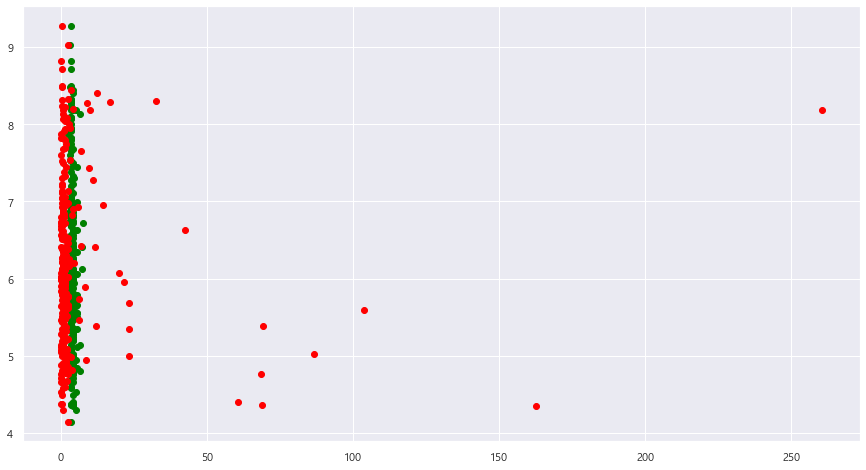

In [524]:
x1 = test.loc[:,'As_value']
x2 = test.loc[:,'As_real_value']

y = test.loc[:,'pH']

plt.scatter(x1, y, c = 'green')
plt.scatter(x2, y, c = 'red')

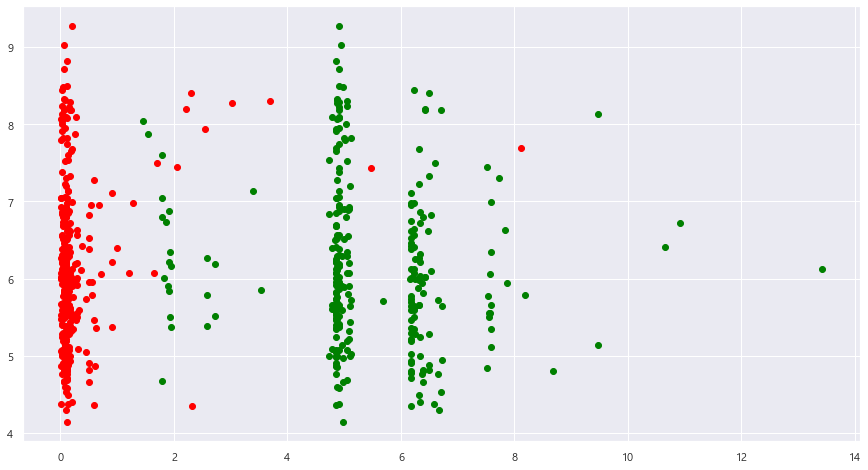

In [525]:
x1 = test.loc[:,'Cd_value']
x2 = test.loc[:,'Cd_real_value']

y = test.loc[:,'pH']

plt.scatter(x1, y, c = 'green')
plt.scatter(x2, y, c = 'red')

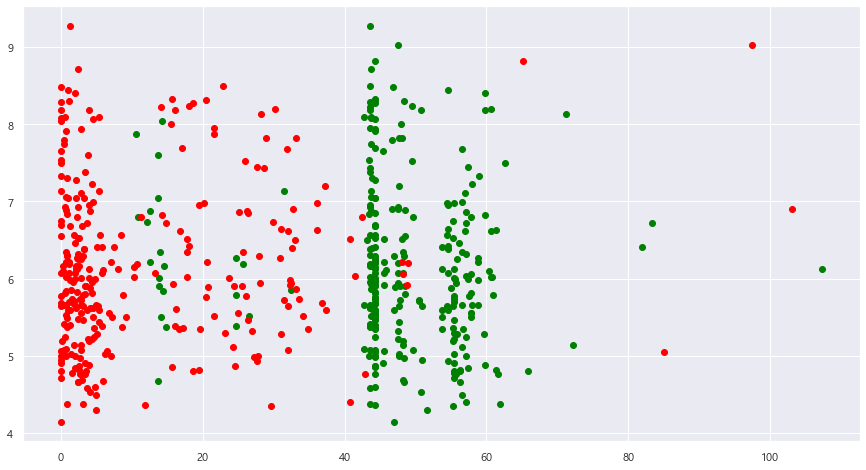

In [526]:
x1 = test.loc[:,'Ni_value']
x2 = test.loc[:,'Ni_real_value']

y = test.loc[:,'pH']

plt.scatter(x1, y, c = 'green')
plt.scatter(x2, y, c = 'red')